In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from feature_engine.imputation import CategoricalImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_app = pd.read_csv('applicant.csv')
df_loan = pd.read_csv('loan.csv')

In [3]:
df = df_app.merge(df_loan, on="applicant_id", how = 'inner')

In [4]:
df.shape

(1000, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   applicant_id                                              1000 non-null   int64 
 1   Primary_applicant_age_in_years                            1000 non-null   int64 
 2   Gender                                                    1000 non-null   object
 3   Marital_status                                            1000 non-null   object
 4   Number_of_dependents                                      1000 non-null   int64 
 5   Housing                                                   1000 non-null   object
 6   Years_at_current_residence                                1000 non-null   int64 
 7   Employment_status                                         1000 non-null   object
 8   Has_been_employed_for_at_leas

In [6]:
df.describe()

,applicant_id,Primary_applicant_age_in_years,Number_of_dependents,Years_at_current_residence,Foreign_worker,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,high_risk_applicant
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.514763e+06,35.546000,1.155000,2.845000,0.963000,20.903000,3.271258e+06,2.973000,0.041000,0.052000,1.407000,0.300000
std,2.286764e+05,11.375469,0.362086,1.103718,0.188856,12.058814,2.822737e+06,1.118715,0.198389,0.222138,0.577654,0.458487
min,1.105364e+06,19.000000,1.000000,1.000000,0.000000,4.000000,2.500000e+05,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.321398e+06,27.000000,1.000000,2.000000,1.000000,12.000000,1.365500e+06,2.000000,0.000000,0.000000,1.000000,0.000000
50%,1.529114e+06,33.000000,1.000000,3.000000,1.000000,18.000000,2.319500e+06,3.000000,0.000000,0.000000,1.000000,0.000000
75%,1.707752e+06,42.000000,1.000000,4.000000,1.000000,24.000000,3.972250e+06,4.000000,0.000000,0.000000,2.000000,1.000000
max,1.903505e+06,75.000000,2.000000,4.000000,1.000000,72.000000,1.842400e+07,4.000000,1.000000,1.000000,4.000000,1.000000


In [7]:
df.isnull().sum()

applicant_id                                                  0
Primary_applicant_age_in_years                                0
Gender                                                        0
Marital_status                                                0
Number_of_dependents                                          0
Housing                                                       0
Years_at_current_residence                                    0
Employment_status                                             0
Has_been_employed_for_at_least                               62
Has_been_employed_for_at_most                               253
Telephone                                                   596
Foreign_worker                                                0
Savings_account_balance                                     183
Balance_in_existing_bank_account_(lower_limit_of_bucket)    668
Balance_in_existing_bank_account_(upper_limit_of_bucket)    457
loan_application_id                     

## Missing values

In [8]:
df.isnull().sum()/len(df) * 100

applicant_id                                                 0.0
Primary_applicant_age_in_years                               0.0
Gender                                                       0.0
Marital_status                                               0.0
Number_of_dependents                                         0.0
Housing                                                      0.0
Years_at_current_residence                                   0.0
Employment_status                                            0.0
Has_been_employed_for_at_least                               6.2
Has_been_employed_for_at_most                               25.3
Telephone                                                   59.6
Foreign_worker                                               0.0
Savings_account_balance                                     18.3
Balance_in_existing_bank_account_(lower_limit_of_bucket)    66.8
Balance_in_existing_bank_account_(upper_limit_of_bucket)    45.7
loan_application_id      

The collumns 'Other_EMI_plans', 'Telephone', 'Balance_in_existing_bank_account_(lower_limit_of_bucket)', 'Balance_in_existing_bank_account_(upper_limit_of_bucket)' has too many missing values. 

In [9]:
df.Telephone.value_counts()

Registered under the applicant's name    404
Name: Telephone, dtype: int64

- Telephone column has only one value. Hence we can drop this column. 
- Other_EMI_plans column has more than 80% value as missing. Hence we should drop this column too. 

### Chi square test to test independence

Chi square test is used to measure the independence of two categorical variables. 

For our Chi-square test for independence here, the null hypothesis is that there is no significant relationship between the columns.

When X² is larger than a threshold, we know the p-value (probability of having a such as large X² given the null hypothesis) is extremely low, and we would reject the null hypothesis.

We consider the significance level of 0.05. 

In [10]:
ct = pd.crosstab(df['Balance_in_existing_bank_account_(lower_limit_of_bucket)'], 
                         df['Balance_in_existing_bank_account_(upper_limit_of_bucket)'], margins=True)
ct

Balance_in_existing_bank_account_(upper_limit_of_bucket),2 lac,All
Balance_in_existing_bank_account_(lower_limit_of_bucket),,
0,269,269
All,269,269


In [11]:
obs = np.array(ct)
chi2_contingency(obs)[0:3]

(0.0, 1.0, 1)

the three terms are X² statistic, p-value, and degree of freedom

- p value = 1 means we fail to reject the null hypothesis that these two columns have no significant relationship between them. 


In [12]:
ct_lower = pd.crosstab(df['Balance_in_existing_bank_account_(lower_limit_of_bucket)'], 
                         df['high_risk_applicant'], margins=True)
ct_lower

high_risk_applicant,0,1,All
Balance_in_existing_bank_account_(lower_limit_of_bucket),,,
0,164,105,269
2 lac,49,14,63
All,213,119,332


In [13]:
chi2_contingency(ct_lower)[0:3]

(6.273408786986648, 0.1796391858516706, 4)

- p value > 0.05 hence we fail to reject the null hypothesis. 
- Balance_in_existing_bank_account_(lower_limit_of_bucket) and high_risk_applicant has no significant relationship between them. 

In [14]:
ct_upper = pd.crosstab(df['Balance_in_existing_bank_account_(upper_limit_of_bucket)'], 
                         df['high_risk_applicant'], margins=True)
ct_upper

high_risk_applicant,0,1,All
Balance_in_existing_bank_account_(upper_limit_of_bucket),,,
0,139,135,274
2 lac,164,105,269
All,303,240,543


In [15]:
chi2_contingency(ct_upper)[0:3]

(5.767154747198731, 0.21722520745291207, 4)

- p value > 0.05 hence we fail to reject the null hypothesis. 
- Balance_in_existing_bank_account_(upper_limit_of_bucket) and high_risk_applicant has no significant relationship between them. 

### Feature Selection based on missing values and independence

##### We can drop the columns 'Telephone', 'Other_EMI_plans', 'Balance_in_existing_bank_account_(lower_limit_of_bucket) ', 'Balance_in_existing_bank_account_(upper_limit_of_bucket)'

In [16]:
df_new = df.drop(['Telephone', 'Other_EMI_plans', 'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
                   'Balance_in_existing_bank_account_(upper_limit_of_bucket)'], axis = 1)
df_new.shape

(1000, 23)

- For rest of the columns with missing values we will impute them

### Imputing missing values

In [17]:
df_new.isnull().sum()

applicant_id                                     0
Primary_applicant_age_in_years                   0
Gender                                           0
Marital_status                                   0
Number_of_dependents                             0
Housing                                          0
Years_at_current_residence                       0
Employment_status                                0
Has_been_employed_for_at_least                  62
Has_been_employed_for_at_most                  253
Foreign_worker                                   0
Savings_account_balance                        183
loan_application_id                              0
Months_loan_taken_for                            0
Purpose                                         12
Principal_loan_amount                            0
EMI_rate_in_percentage_of_disposable_income      0
Property                                       154
Has_coapplicant                                  0
Has_guarantor                  

In [18]:
cat_columns = ['Has_been_employed_for_at_least', 'Has_been_employed_for_at_most', 'Savings_account_balance',
              'Purpose', 'Property']

imputer = CategoricalImputer(variables= cat_columns, imputation_method = 'frequent')

df_new = imputer.fit_transform(df_new)

In [19]:
df_new.isnull().sum()

applicant_id                                   0
Primary_applicant_age_in_years                 0
Gender                                         0
Marital_status                                 0
Number_of_dependents                           0
Housing                                        0
Years_at_current_residence                     0
Employment_status                              0
Has_been_employed_for_at_least                 0
Has_been_employed_for_at_most                  0
Foreign_worker                                 0
Savings_account_balance                        0
loan_application_id                            0
Months_loan_taken_for                          0
Purpose                                        0
Principal_loan_amount                          0
EMI_rate_in_percentage_of_disposable_income    0
Property                                       0
Has_coapplicant                                0
Has_guarantor                                  0
Number_of_existing_l

## Finding outliers for continuous variables

<AxesSubplot:xlabel='Primary_applicant_age_in_years'>

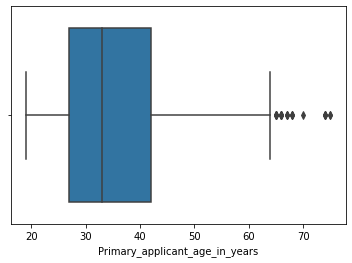

In [20]:
sns.boxplot(df_new['Primary_applicant_age_in_years'])

<AxesSubplot:xlabel='Months_loan_taken_for'>

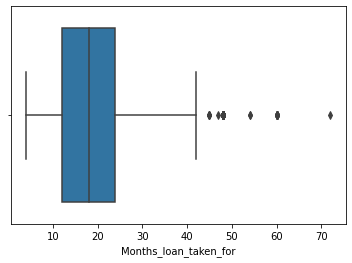

In [21]:
sns.boxplot(df_new['Months_loan_taken_for'])

<AxesSubplot:xlabel='Principal_loan_amount'>

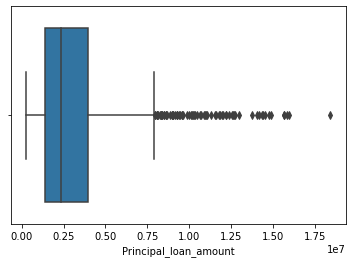

In [22]:
sns.boxplot(df_new['Principal_loan_amount'])

All of the continuous data are rightly skewed.

We will use IQR method for finding the outliers.

In [23]:
#function to find the outliers
def find_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3 - q1
    outliers = data[((data < (q1-1.5*IQR))|(data >( q3+1.5*IQR)))]
    return outliers

In [24]:
columns = ['Primary_applicant_age_in_years', 'Months_loan_taken_for', 'Principal_loan_amount']
for col in columns:
    outliers = find_outliers(df_new[col])
    #percent = len(outliers)/len(df) * 100
    print('number of outliers in '+ col + ' : '+ str(len(outliers)) )

number of outliers in Primary_applicant_age_in_years : 23
number of outliers in Months_loan_taken_for : 70
number of outliers in Principal_loan_amount : 72


In [25]:
# cap the outliers

'''To cap the outliers, calculate a upper limit and lower limit. For the upper limit, we will use 
the mean plus three standard deviations. For the lower limit, we will calculate it as 
the mean minus 3 standard deviations.'''

def cap_outliers(data):
    upper_limit = int(data.mean() + 3*data.std())
    lower_limit = int(data.mean() - 3*data.std())
    
    data = np.where(data > upper_limit, upper_limit,
                   np.where(data < lower_limit, lower_limit, data))
    return data

In [26]:
columns = ['Primary_applicant_age_in_years', 'Months_loan_taken_for', 'Principal_loan_amount']
for col in columns:
    #print (col)
    df_new[col] = cap_outliers(df_new[col])

## Multicolinearity

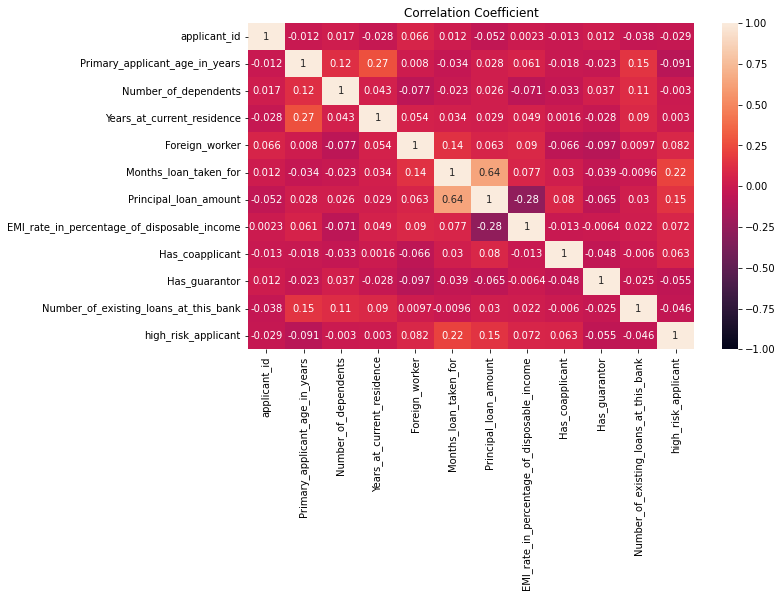

In [27]:
fig , ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_new.corr(), annot=True, vmin=-1, vmax=1)
plt.title('Correlation Coefficient')
plt.show()

- 'Principal_loan_amount' is moderately correlated with 'Months_loan_taken_for'. 
    - EMI payment is directly proportional to the loan amount but inversely proportional to the tenure of the loan. More the principal of loan, the amount the borrower has to pay more amount on schedule dent payments. Hence more the tenure of the loan, the amount of scheduled debt decreases. This explains the postive correlation. 

-  'EMI_rate_in_percentage_of_disposable_income' shows a weak negative linear relationship with 'Principal_loan_amount'.
    - EMI payment is directly proportional to both the interest rate and the loan amount. Hence if the loan provider wants to keep the amount of EMI fixed, for a smaller loan amount they have to increase the EMI rate and vice versa. This explains the negative correlation. 

- 'Years_at_current_residence' has a weak positive correlation with 'Primary_applicant_age_in_years'
    - It is more likely for an old age applicant to be in their current residence for more years than that of a young age applicant. 
    
- 'Months_loan_taken_for' shows a weak positive correlation with 'high_risk_applicant'. 
     - This may be due to the fact that with months there is a probability of default - the likelihood that borrower will not maintain the financial capability to make scheduled debt payments.  

- 'Number_of_dependents' is weakly correlated with 'Primary_applicant_age_in_years' 
    - This can be explained from the fact that more the age of the applicant it is more likely for that person to have children or family members(spouse) who qualify as their dependent. Hence the positive correlation. 

#### Calculating VIF

In [28]:
df.select_dtypes(include=['int64']).columns

Index(['applicant_id', 'Primary_applicant_age_in_years',
       'Number_of_dependents', 'Years_at_current_residence', 'Foreign_worker',
       'Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant'],
      dtype='object')

In [29]:
X_variables = df_new[['Primary_applicant_age_in_years',
       'Number_of_dependents', 'Years_at_current_residence', 'Foreign_worker',
       'Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant' ]]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
3,Foreign_worker,16.935367
0,Primary_applicant_age_in_years,11.662373
1,Number_of_dependents,9.629448
6,EMI_rate_in_percentage_of_disposable_income,9.312624
2,Years_at_current_residence,8.081224
4,Months_loan_taken_for,8.078294
9,Number_of_existing_loans_at_this_bank,6.936133
5,Principal_loan_amount,5.202227
10,high_risk_applicant,1.533963
8,Has_guarantor,1.062786


As shown in the table 'Foreign_worker', 'Primary_applicant_age_in_years', 'Number_of_dependents', 'EMI_rate_in_percentage_of_disposable_income', 'Years_at_current_residence', 'Months_loan_taken_for', 'Number_of_existing_loans_at_this_bank', 'Principal_loan_amount' all have VIF value exceeding 5. 

- We will try removing features one at a time and calculate the VIF 

In [30]:
#remove Foreign_worker
X_variables = df_new[['Primary_applicant_age_in_years',
       'Number_of_dependents', 'Years_at_current_residence',
       'Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant' ]]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
0,Primary_applicant_age_in_years,11.149086
1,Number_of_dependents,8.923146
5,EMI_rate_in_percentage_of_disposable_income,8.241615
3,Months_loan_taken_for,7.957676
2,Years_at_current_residence,7.763350
8,Number_of_existing_loans_at_this_bank,6.707530
4,Principal_loan_amount,5.154377
9,high_risk_applicant,1.524850
7,Has_guarantor,1.062123
6,Has_coapplicant,1.055229


In [31]:
#remove Primary_applicant_age_in_years

X_variables = df_new[['Number_of_dependents', 'Years_at_current_residence',
       'Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant' ]]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
0,Number_of_dependents,8.103050
2,Months_loan_taken_for,7.930322
4,EMI_rate_in_percentage_of_disposable_income,7.616082
1,Years_at_current_residence,6.728636
7,Number_of_existing_loans_at_this_bank,6.406723
3,Principal_loan_amount,5.039221
8,high_risk_applicant,1.515665
6,Has_guarantor,1.062113
5,Has_coapplicant,1.055221


In [32]:
#remove Number_of_dependents

X_variables = df_new[['Years_at_current_residence',
       'Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant' ]]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
1,Months_loan_taken_for,7.929794
3,EMI_rate_in_percentage_of_disposable_income,7.000491
0,Years_at_current_residence,6.125008
6,Number_of_existing_loans_at_this_bank,5.622514
2,Principal_loan_amount,4.925006
7,high_risk_applicant,1.513602
4,Has_coapplicant,1.054997
5,Has_guarantor,1.053273


In [33]:
#remove Months_loan_taken_for

X_variables = df_new[['Years_at_current_residence',
        'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant' ]]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
0,Years_at_current_residence,6.117190
2,EMI_rate_in_percentage_of_disposable_income,5.651144
5,Number_of_existing_loans_at_this_bank,5.620141
1,Principal_loan_amount,2.418149
6,high_risk_applicant,1.488643
3,Has_coapplicant,1.053508
4,Has_guarantor,1.052743


In [34]:
#remove Years_at_current_residence

X_variables = df_new[['Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Has_coapplicant',
       'Has_guarantor', 'Number_of_existing_loans_at_this_bank',
       'high_risk_applicant' ]]

vif_data = pd.DataFrame()
vif_data['feature'] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values('VIF', ascending = False)

,feature,VIF
4,Number_of_existing_loans_at_this_bank,4.862685
1,EMI_rate_in_percentage_of_disposable_income,4.384847
0,Principal_loan_amount,2.252794
5,high_risk_applicant,1.487890
2,Has_coapplicant,1.053392
3,Has_guarantor,1.051831


Now the VIF is all within the acceptable range and the model will give a statistically significant result. 

- But for training the model in our case we will consider the features as long as the VIF values are not exceeding 10 (for simplicity and for avoidiing dropping too many columns) 

### Feature Selection based on VIF

In [35]:
#drop Foreign_worker and Primary_applicant_age_in_years

df_final = df_new.drop(['Foreign_worker', 'Primary_applicant_age_in_years'], axis = 1)
df_final.shape

(1000, 21)

### Removing redundant features

In [121]:
#drop applicant_id and loan_application_id as these are just ids
df_final = df_final.drop(['applicant_id', 'loan_application_id'], axis = 1)
df_final.shape

(1000, 19)

## Label encoding the categorical features

In [122]:
#LABEL ENCODING

#selecting categorical columns to encode from dataset

cat_columns = list(df_final.select_dtypes("object").columns)

#setting up the imputer 

transformer = ColumnTransformer(transformers = [("L", OrdinalEncoder(),cat_columns)], remainder = 'passthrough')
cat_columns_imputed = transformer.fit_transform(df_final[cat_columns])

#passing the imputer values in each of the categorical columns in the original dataset

df_final[cat_columns] = cat_columns_imputed

In [123]:
df_final.head()

,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Savings_account_balance,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
0,1.0,3.0,1,1.0,4,1.0,3.0,2.0,1.0,6,5.0,1169000,4,2.0,0,0,2,1.0,0
1,0.0,1.0,1,1.0,2,1.0,1.0,2.0,1.0,48,5.0,5951000,2,2.0,0,0,1,3.0,1
2,1.0,3.0,2,1.0,3,3.0,2.0,3.0,1.0,12,4.0,2096000,2,2.0,0,0,1,1.0,0
3,1.0,3.0,2,0.0,4,1.0,2.0,3.0,1.0,42,0.0,7882000,2,0.0,0,1,1,3.0,0
4,1.0,3.0,2,0.0,4,1.0,1.0,2.0,1.0,24,6.0,4870000,3,1.0,0,0,2,2.0,1


## Train Test Splitting

In [124]:
X = df_final.drop(['high_risk_applicant'], axis = 1)
y = df_final.high_risk_applicant

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100 )

## ML model fitting

##### Business Constraint:
- Note that it is worse to state an applicant as a low credit risk when they are actually a high risk, than it is to state an applicant to be a high credit risk when they aren’t.

It means False Positive is more acceptable than False Negative. 

- To favour the false negatives we have used scorer = 'recall'. 
- We have also used SMOTE and SMOTEEN for countering the class imbalance.

### 1. Fitting Decision Tree with randomized search cv for hyperparamter tuning


In [126]:
kf = KFold(n_splits=5, shuffle=False)

In [127]:
params = {"decisiontreeclassifier__max_depth": range(2,50,5),
              "decisiontreeclassifier__min_samples_split": [10, 20, 50],
              "decisiontreeclassifier__min_samples_leaf": [2, 4, 8],
              "decisiontreeclassifier__criterion": ["gini", "entropy"]}

In [128]:
#As the data is moderately imbalanced we are using SMOTE for minority oversampling technique


DT_pipeline = make_pipeline(SMOTE(random_state=42), 
                              DecisionTreeClassifier(random_state=10))

clf = RandomizedSearchCV(DT_pipeline, param_distributions=params, cv = kf,
                         scoring='recall', return_train_score = True, verbose = 10)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=22, decisiontreeclassifier__min_samples_leaf=8, decisiontreeclassifier__min_samples_split=10
[CV 1/5; 1/10] END decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=22, decisiontreeclassifier__min_samples_leaf=8, decisiontreeclassifier__min_samples_split=10;, score=(train=0.718, test=0.452) total time=   0.0s
[CV 2/5; 1/10] START decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=22, decisiontreeclassifier__min_samples_leaf=8, decisiontreeclassifier__min_samples_split=10
[CV 2/5; 1/10] END decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=22, decisiontreeclassifier__min_samples_leaf=8, decisiontreeclassifier__min_samples_split=10;, score=(train=0.678, test=0.489) total time=   0.0s
[CV 3/5; 1/10] START decisiontreeclassifier__criterion=entropy, decisiont

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier(random_state=10))]),
                   param_distributions={'decisiontreeclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'decisiontreeclassifier__max_depth': range(2, 50, 5),
                                        'decisiontreeclassifier__min_samples_leaf': [2,
                                                                                     4,
                                                                                     8],
                                        'decisiontreeclassifier__min_samples_split': [10,
                                                                                      20,
                                                                                      50]},
                   return_train_score=True, scoring='recall', verbose=10)

In [129]:
clf.best_params_

{'decisiontreeclassifier__min_samples_split': 10,
 'decisiontreeclassifier__min_samples_leaf': 4,
 'decisiontreeclassifier__max_depth': 7,
 'decisiontreeclassifier__criterion': 'entropy'}

In [130]:
DT_model = make_pipeline(SMOTE(random_state=42), 
                              DecisionTreeClassifier(min_samples_split= 10,
                                                     min_samples_leaf= 4,
                                                     max_depth= 7,
                                                     criterion= 'entropy',
                                                     random_state=10))

In [131]:
DT_model.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=10))])

In [132]:
y_pred=DT_model.predict(X_test)

#### DT Model Evaluation

In [133]:
confusion_matrix(y_test, y_pred)

array([[119,  25],
       [ 40,  16]])

<AxesSubplot:>

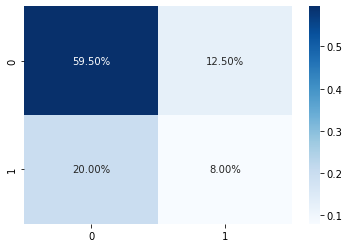

In [134]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       144
           1       0.39      0.29      0.33        56

    accuracy                           0.68       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.65      0.68      0.66       200



In [136]:
print('Accuracy score for DT model: ', accuracy_score (y_test, y_pred))

Accuracy score for DT model:  0.675


## 2. Random Forest with RandomizedSearchCV for hyperparameter tuning

In [137]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap}

In [138]:
RF_pipeline = make_pipeline(SMOTEENN (random_state=42), 
                              RandomForestClassifier(random_state=10))

clf_rf = RandomizedSearchCV(RF_pipeline, param_distributions=random_grid, cv = kf,
                         scoring='recall', return_train_score = True, verbose = 10)

clf_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=800
[CV 1/5; 1/10] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=800;, score=(train=0.470, test=0.333) total time=   0.5s
[CV 2/5; 1/10] START randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=800
[CV 2/5; 1/10] END randomforestclassifier__bootstrap=True, randomforestc

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smoteenn',
                                              SMOTEENN(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=10))]),
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [10,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50,
                                                                              60,
                                                                              70,
                                                                              80,
                                                                              90,
                                                                              100,
                                                                              110,
                                                                              None],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [200,
                                                                                 400,
                                                                                 600,
                                                                                 800,
                                                                                 1000,
                                                                                 1200,
                                                                                 1400,
                                                                                 1600,
                                                                                 1800,
                                                                                 2000]},
                   return_train_score=True, scoring='recall', verbose=10)

In [139]:
clf_rf.best_params_

{'randomforestclassifier__n_estimators': 800,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__bootstrap': True}

In [140]:
RF_model = make_pipeline(SMOTEENN(random_state=42), 
                              RandomForestClassifier(n_estimators = 800,
                                                    min_samples_split= 10,
                                                     min_samples_leaf= 1,
                                                     max_features = 'sqrt',
                                                     max_depth= 10,
                                                     bootstrap = True,
                                                     random_state=10))

In [141]:
RF_model.fit(X_train, y_train)

Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=10,
                                        n_estimators=800, random_state=10))])

In [142]:
y_pred_rf=RF_model.predict(X_test)

### RF model Evaluation

In [143]:
confusion_matrix(y_test, y_pred_rf)

array([[116,  28],
       [ 38,  18]])

<AxesSubplot:>

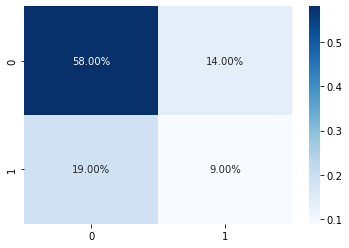

In [144]:
cf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [145]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       144
           1       0.39      0.32      0.35        56

    accuracy                           0.67       200
   macro avg       0.57      0.56      0.57       200
weighted avg       0.65      0.67      0.66       200



In [146]:
print('Accuracy for RF model: ', accuracy_score (y_test, y_pred_rf))

Accuracy for RF model:  0.67


## 3. XGBoost Classifier

### Without hyperparameter tuning

In [147]:
model = XGBClassifier()
model.fit(X_train, y_train)

[17:50:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [148]:
y_pred_xg = model.predict(X_test)

In [149]:
confusion_matrix(y_test, y_pred_xg)

array([[125,  19],
       [ 40,  16]])

<AxesSubplot:>

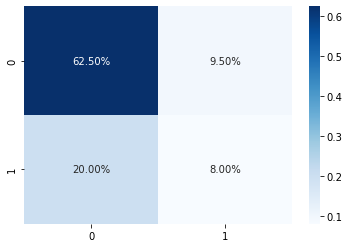

In [150]:
cf = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [151]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       144
           1       0.46      0.29      0.35        56

    accuracy                           0.70       200
   macro avg       0.61      0.58      0.58       200
weighted avg       0.67      0.70      0.68       200



In [152]:
print('Accuracy of XGB model without hyperparameter tuning: ', accuracy_score(y_test, y_pred_xg))

Accuracy of XGB model without hyperparameter tuning:  0.705


### With hyperparameter tuning and using SMOTE

In [153]:
xg_params = {"xgbclassifier__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "xgbclassifier__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ],
             "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [154]:
XGB_pipeline = make_pipeline( SMOTE(random_state=42), 
                              XGBClassifier(random_state=10))

clf_xgb = RandomizedSearchCV(XGB_pipeline, param_distributions=xg_params, cv = kf,
                         scoring='recall', return_train_score = True, verbose = 10)

clf_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START xgbclassifier__colsample_bytree=0.5, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=12, xgbclassifier__min_child_weight=5
[17:51:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 1/10] END xgbclassifier__colsample_bytree=0.5, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=12, xgbclassifier__min_child_weight=5;, score=(train=0.906, test=0.429) total time=   0.3s
[CV 2/5; 1/10] START xgbclassifier__colsample_bytree=0.5, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.15, xgbclassifier__max_depth=12, xgbclassifier__min_child_weight=5
[17:51:15] WARNING: /User

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,
                                                            interaction_constraints...
                                                            validate_parameters=None,
                                                            verbosity=None))]),
                   param_distributions={'xgbclassifier__colsample_bytree': [0.3,
                                                                            0.4,
                                                                            0.5,
                                                                            0.7],
                                        'xgbclassifier__gamma': [0.0, 0.1, 0.2,
                                                                 0.3, 0.4],
                                        'xgbclassifier__learning_rate': [0.05,
                                                                         0.1,
                                                                         0.15,
                                                                         0.2,
                                                                         0.25,
                                                                         0.3],
                                        'xgbclassifier__max_depth': [3, 4, 5, 6,
                                                                     8, 10, 12,
                                                                     15],
                                        'xgbclassifier__min_child_weight': [1,
                                                                            3,
                                                                            5,
                                                                            7]},
                   return_train_score=True, scoring='recall', verbose=10)

In [155]:
clf_xgb.best_params_

{'xgbclassifier__min_child_weight': 3,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__learning_rate': 0.3,
 'xgbclassifier__gamma': 0.1,
 'xgbclassifier__colsample_bytree': 0.5}

In [156]:
XGB_model = make_pipeline( SMOTE(random_state=42), 
                              XGBClassifier(min_child_weight = 3,
                                            max_depth= 3,
                                            learning_rate= 0.3,
                                            gamma = 0.1,
                                            colsample_bytree= 0.5,
                                            random_state = 10 ))

In [157]:
XGB_model.fit(X_train, y_train)

[17:51:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, enable_categorical=False,
                               gamma=0.1, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=10, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [158]:
y_pred_xgb=XGB_model.predict(X_test)

In [159]:
confusion_matrix(y_test, y_pred_xgb)

array([[122,  22],
       [ 43,  13]])

<AxesSubplot:>

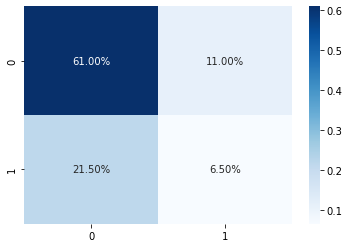

In [160]:
cf = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [161]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.37      0.23      0.29        56

    accuracy                           0.68       200
   macro avg       0.56      0.54      0.54       200
weighted avg       0.64      0.68      0.65       200



In [162]:
print('Accuracy of XGB model with hyperparameter tuning: ', accuracy_score(y_test, y_pred_xgb))

Accuracy of XGB model with hyperparameter tuning:  0.675


### Model to select based on Metric

Recall = TP/TP+FN

We need to minimize the False Negative hence we need to choose the model which have the best Recall score. 

##### - Among these classifiers we can see XGBoost gives the best Recall score. 


 

## How to export and deploy the model

In [107]:
'''If we want to save the XGBoost model to the disc we must use pickle library. 
The following is an example of how we can store the trained model in a pickle file.'''
import pickle

with open('model.pkl', 'wb') as files:
    pickle.dump(model, files)
print("Model Saved")

Model Saved


In [112]:
'''Then for loading the model again and predicting on some test data we can do the following'''
xgb_model = pickle.load(open('model.pkl','rb'))

y_pred_test = xgb_model.predict(X_test)

'''For deploying the model we need to build a REST API(e.g. using FLASK) which will create the web application object
and render the data from html GUI to make the prediction. We can then host the app in a preferable 
cloud environment'''

## Creating Dashboard

In [110]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(xgb_model, X_test, y_test)


Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [111]:
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explai

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8050
 * Running on http://192.168.0.5:8050 (Press CTRL+C to quit)
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET /assets/bootstrap.min.css?m=1662893488.013996 HTTP/1.1" 304 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Sep/2022 17:11:05] "POST /_dash-update-comp

## Realworld Data features

In [119]:
df.columns

Index(['applicant_id', 'Primary_applicant_age_in_years', 'Gender',
       'Marital_status', 'Number_of_dependents', 'Housing',
       'Years_at_current_residence', 'Employment_status',
       'Has_been_employed_for_at_least', 'Has_been_employed_for_at_most',
       'Telephone', 'Foreign_worker', 'Savings_account_balance',
       'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
       'Balance_in_existing_bank_account_(upper_limit_of_bucket)',
       'loan_application_id', 'Months_loan_taken_for', 'Purpose',
       'Principal_loan_amount', 'EMI_rate_in_percentage_of_disposable_income',
       'Property', 'Has_coapplicant', 'Has_guarantor', 'Other_EMI_plans',
       'Number_of_existing_loans_at_this_bank', 'Loan_history',
       'high_risk_applicant'],
      dtype='object')

1. **Debt to Income Ratio**:
    - A clear indication of DTI helps the lenders to decide if the applicant is creditworthy. It signifies less risk for the lenders as it indicates the capacity of the applicant to take on an additional monthly debt payment. Hence a quantitative feature indicating DTI ratio for all of the applicants would have helped the analysis. 

2. **Credit score**:
    - A quantitative analysis of credit score helps lenders to measure credit risk. Including credit score as a feature might have made the data analysis more simpler. 